In [1]:
import torch
from torch.utils.data import Dataset, DataLoader


import torch.nn as nn
import torch.optim as optim
from torchvision import datasets


import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
fmnist = datasets.FashionMNIST("./fashionMNIST", train=True, download=True)
val_fmnist = datasets.FashionMNIST("./fashionMNIST_val/", train=False, download=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
fmnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

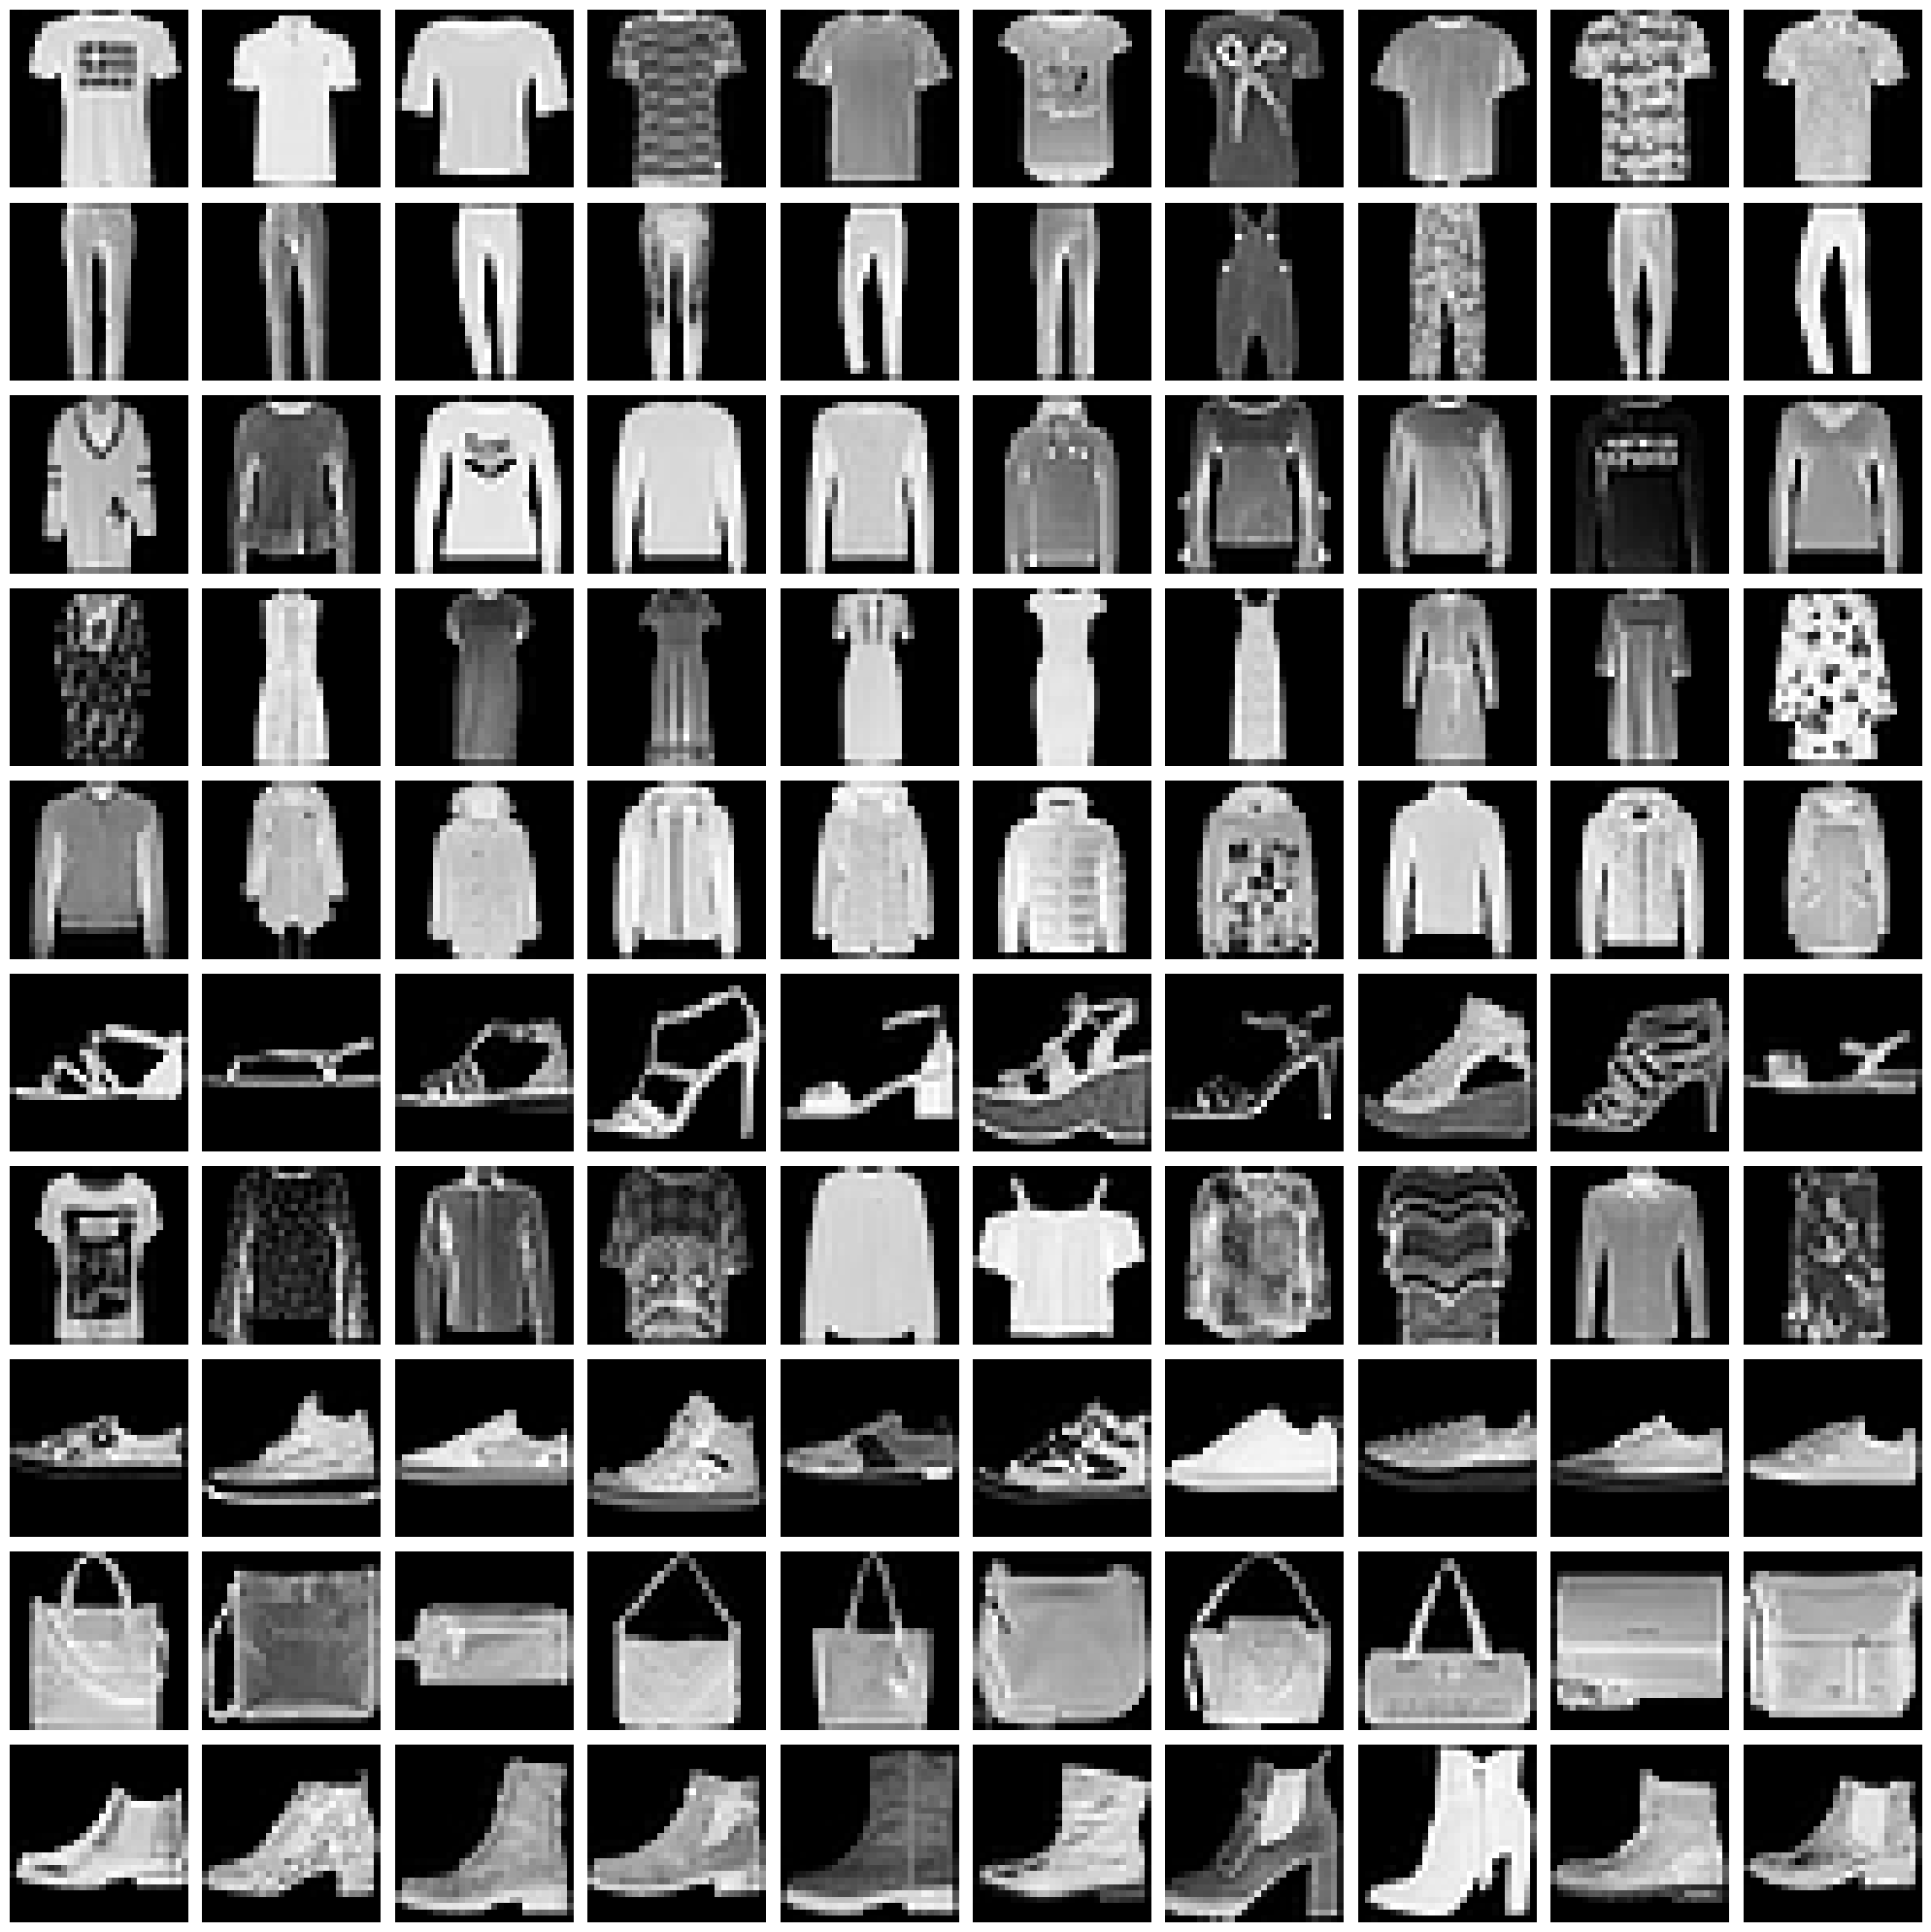

In [4]:
R, C = len(tr_targets.unique(dim=0)), 10
fig, ax = plt.subplots(R, C, figsize=(20, 20))

for class_label, row in enumerate(ax):  # type: ignore
    label_x_rows = np.where(tr_targets == class_label)[0]

    for cell in row:
        cell.grid(False)
        cell.axis('off')
        i = np.random.choice(label_x_rows)
        cell.imshow(tr_images[i], cmap='gray')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(20, 20))

for label_class, c_name in enumerate(fmnist.classes):

    label_x_rows = np.where(tr_targets == label_class)

    for i in range(10):
        rand_idx = np.random.randint(0, len(label_x_rows[0]))
        plt.subplot(10, 10, label_class * 10 + i + 1)

        plt.imshow(tr_images[label_x_rows[0][rand_idx]], cmap='gray')

In [7]:
class FMNISTDataSet(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        super().__init__()
        self.x = x.float().view(x.shape[0], -1) / 255
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]


trn_ds = FMNISTDataSet(tr_images, tr_targets)
trn_dataloader = DataLoader(trn_ds, batch_size=64, shuffle=True)

In [8]:
def get_model(lr=0.001):
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.Sigmoid(),
        nn.Linear(1000, 10)
    ).to(device)

    optimizer = optim.SGD(model.parameters(), lr)
    lossFn = nn.CrossEntropyLoss()

    return model, optimizer, lossFn

In [9]:
def train_batch(x: torch.Tensor, y: torch.Tensor, model: nn.Module, opt: optim.Optimizer, lossFn):
    model.train()

    _y = model(x)
    loss = lossFn(_y, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    return loss.item()

In [10]:
@torch.no_grad()
def measure_accuracy(x, y, model):
    x = x.float().view(x.shape[0], -1)
    return (model(x).argmax(dim=1) == y).sum() / y.shape[0]

In [11]:
def train_loop(model: nn.Module, opt: optim.Optimizer, lossFn, epochs=10):
    losses = []
    accuracies = []

    for epoch in range(epochs):
        loss = 0
        for x, y in trn_dataloader:
            loss = train_batch(x, y, model, opt, lossFn)

        losses.append(loss)
        accuracies.append(measure_accuracy(val_fmnist.data, val_fmnist.targets, model))
        print(epoch)

    
    return losses, accuracies

In [12]:
model, opt, lossFn = get_model()
epochs = 2

losses, accuracies = train_loop(model, opt, lossFn, epochs)

KeyboardInterrupt: 

(array([4., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

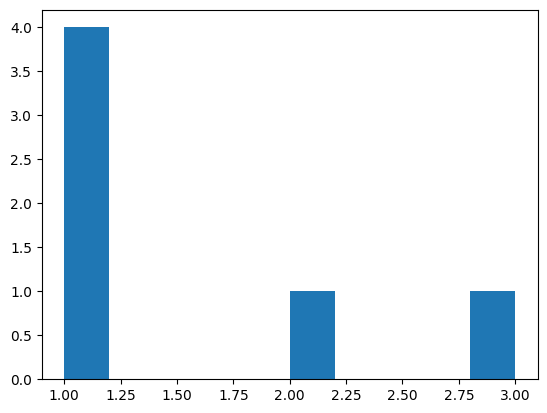

In [16]:
plt.hist([1,2,3, 1, 1, 1])